# Model Selection
Model selection is a critical step in the modeling procedure where you compare, evaluate, and choose the best predictive model from a set of candidates. The goal of model selection is to identify the model that will perform best on future data, not just the training set. The process typically involves:
- Comparing different algorithms (e.g., linear regression, decision trees, random forests, etc.).
- Tuning model hyperparameters to optimize performance.
- Using statistical criteria (such as AIC, BIC, or adjusted R²) and/or validation metrics (such as accuracy, RMSE, ROC-AUC) to assess model quality.
- Employing cross-validation or holdout validation to estimate how well each model generalizes to new, unseen data.
- Selecting the model that best balances predictive accuracy, interpretability, and complexity for your specific problem.

## Initialization

In [1]:
import pandas as pd
import numpy as np
import os
import rich

## Load Data

In [2]:
input_folder = "../.local/analysis_pipeline/data_exploration"
model_data = pd.read_parquet(f"{input_folder}/model_data_09162025.parquet")

## Build Model
This is the base model of our project

In [4]:
# Define the list of predictors
pred_lst = ['agecat2', 'gender', 'credit_score', 'area', 'traffic_index', 'veh_age', 'veh_body', 'veh_value']
# Split the data into training and validation sets
train_data = model_data.loc[model_data['sample'] == '1|bld']
val_data = model_data.loc[model_data['sample'] == '2|val']
rich.print( train_data.shape, val_data.shape )
train_data.head(5)

(37478, 24)
(12522, 24)

,pol_number,pol_eff_dt,agecat,date_of_birth,credit_score,traffic_index,veh_age,veh_value,claim_cnt,claim_amt,...,claim_office,agecat2,pol_year,pol_quarter,veh_cnt,claim_sev,claim_sev_capped,claim_amt_capped,fold,sample
0,5.370332e+07,NaT,-5.985015,NaT,566.644937,72.104017,2.557480,2.289678,1,7228.005540,...,A,NaN,2017,NaN,1,7228.005540,7228.005540,7228.005540,3,1|bld
2,5.627846e+07,NaT,-3.997989,NaT,614.973556,80.482879,2.452349,2.899493,0,0.000000,...,Missing,NaN,2017,NaN,1,NaN,NaN,0.000000,1,1|bld
3,5.491015e+07,NaT,-5.121608,NaT,614.002052,85.560472,2.462938,2.702998,0,0.000000,...,Missing,NaN,2017,NaN,1,NaN,NaN,0.000000,3,1|bld
4,5.371561e+07,NaT,-5.724952,NaT,682.434840,67.920249,2.644569,2.287953,0,0.000000,...,Missing,NaN,2017,NaN,1,NaN,NaN,0.000000,3,1|bld
6,5.678884e+07,NaT,-3.943564,NaT,465.967519,95.454251,2.504635,3.036845,1,501.399798,...,B,NaN,2017,NaN,1,501.399798,501.399798,501.399798,1,1|bld


In [5]:
# XGBoost Tweedie Regression with Cross-Validation Early Stopping and Native Categorical Support
import xgboost as xgb

# Define features and target
y = train_data['claim_amt_capped']
X = train_data[pred_lst].copy()

# Convert object columns to pandas Categorical dtype for XGBoost native categorical support
for col in ['gender', 'area', 'veh_body']:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')

# XGBoost DMatrix for all training data with categorical support
dtrain = xgb.DMatrix(X, label=y, enable_categorical=True)

# Define XGBoost parameters for Tweedie regression
params = {
    'objective': 'reg:tweedie',         # Tweedie regression objective
    'tweedie_variance_power': 1.5,      # Tweedie power (1=Poisson, 2=Gamma, 1<p<2 for insurance)
    'learning_rate': 0.05,              # Step size shrinkage (smaller = more robust, slower learning)
    'max_depth': 4,                     # Maximum tree depth (controls model complexity)
    'min_child_weight': 100,            # Minimum sum of instance weight (hessian) needed in a child (min samples per leaf, set for 45,300 samples)
    'subsample': 0.8,                   # Fraction of samples used per tree (prevents overfitting)
    'colsample_bytree': 0.8,            # Fraction of features used per tree (prevents overfitting)
    'lambda': 1.0,                      # L2 regularization term (prevents overfitting)
    'alpha': 0.0,                       # L1 regularization term (prevents overfitting)
    'nthread': -1,                      # Use all CPU cores
    'seed': 42                          # Random seed for reproducibility
}

# Cross-validation with early stopping
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=1000,
    nfold=5,  # 5-fold cross-validation
    metrics='rmse',  # or another appropriate metric
    early_stopping_rounds=30,
    seed=42,
    verbose_eval=50
 )

# The best number of boosting rounds is:
best_num_boost_round = len(cv_results)
print(f"Best num_boost_round from CV: {best_num_boost_round}")

# Train final model on all data using best_num_boost_round
model = xgb.train(
    params,
    dtrain,
    num_boost_round=best_num_boost_round
 )

# --- Hyper-parameter definitions ---
# objective:      Loss function to optimize (here, Tweedie regression for insurance data)
# tweedie_variance_power: Tweedie power parameter (1=Poisson, 2=Gamma, 1<p<2 for insurance)
# learning_rate:  Step size shrinkage to prevent overfitting (lower = slower, more robust)
# max_depth:      Maximum depth of each tree (higher = more complex, risk of overfitting)
# min_child_weight: Minimum sum of instance weight (hessian) needed in a child (higher = more conservative, prevents overfitting, set to 100 for 45,300 samples)
# subsample:      Fraction of samples used per tree (lower = more regularization)
# colsample_bytree: Fraction of features used per tree (lower = more regularization)
# lambda:         L2 regularization term on weights (higher = more regularization)
# alpha:          L1 regularization term on weights (higher = more regularization)
# nthread:        Number of parallel threads (set to -1 to use all cores)
# seed:           Random seed for reproducibility
# early_stopping_rounds: Stop training if validation metric does not improve for this many rounds

[0]	train-rmse:1398.14789+5.87744	test-rmse:1398.10277+24.41821
[50]	train-rmse:990.24319+6.67422	test-rmse:1001.22052+23.79342
[100]	train-rmse:834.64638+7.82300	test-rmse:857.94265+28.68358
[150]	train-rmse:753.35550+6.67711	test-rmse:788.81431+32.69122
[200]	train-rmse:700.85179+7.13809	test-rmse:746.94384+36.66735
[250]	train-rmse:666.75554+8.07726	test-rmse:740.45696+60.91031
[260]	train-rmse:663.16077+8.83281	test-rmse:740.20848+64.22140
Best num_boost_round from CV: 231


C:\Users\mengjin6\AppData\Local\Temp\ipykernel_24648\1903984692.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['xgb_tweedie_pred'] = train_pred
C:\Users\mengjin6\AppData\Local\Temp\ipykernel_24648\1903984692.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['xgb_tweedie_pred'] = val_pred


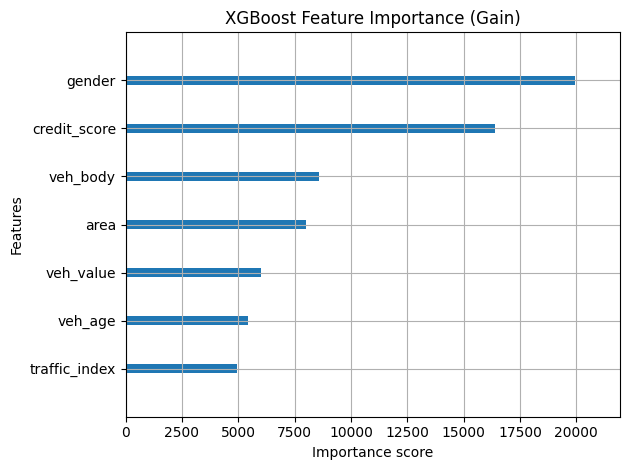

In [6]:
# --- Model Fitting Score and Prediction ---
# Prepare train and validation data for prediction
X_train = train_data[pred_lst].copy()
X_val = val_data[pred_lst].copy()

# Convert object columns to category for both sets
for col in ['gender', 'area', 'veh_body']:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category')
    if X_val[col].dtype == 'object':
        X_val[col] = X_val[col].astype('category')

# DMatrix for prediction
dtrain_pred = xgb.DMatrix(X_train, enable_categorical=True)
dval_pred = xgb.DMatrix(X_val, enable_categorical=True)

# In-sample fitted values
train_pred = model.predict(dtrain_pred)
train_data['xgb_tweedie_pred'] = train_pred

# Out-of-sample prediction on validation set
val_pred = model.predict(dval_pred)
val_data['xgb_tweedie_pred'] = val_pred

# --- Variable Importance Plot ---
import matplotlib.pyplot as plt
xgb.plot_importance(model, importance_type='gain', show_values=False, title='XGBoost Feature Importance (Gain)')
plt.tight_layout()
plt.show()


In [7]:
### Load Base Model Into Memory
output_folder = "../.local/analysis_pipeline/model_selection"
os.makedirs(output_folder, exist_ok=True)
model.save_model(f"{output_folder}/xgb_tweedie_model_09162025.json")

## Model Evaluation
Below please find resources on different model evaluation metrics:
1. Gini coefficient: The Gini coefficient is a statistical measure of inequality, but in the context of the Casualty Actuarial Society (CAS), it is used to evaluate the effectiveness of predictive models, such as those used for insurance ratemaking. In this application, a Gini index measures how well a model's predictions (like for pure premium or risk scores) distinguish between high-risk and low-risk policyholders, with a higher Gini coefficient indicating better model performance. (Source: Search "Gini coefficient Casualty Actuarial Society").
2. https://www.casact.org/sites/default/files/presentation/rpm_2019_presentations_m-4_williams.pdf

### On training data

Top Lift: 7.6323
Gini: 0.8686
R^2: 0.7667
RMSE: 680.29
MAE: 264.06


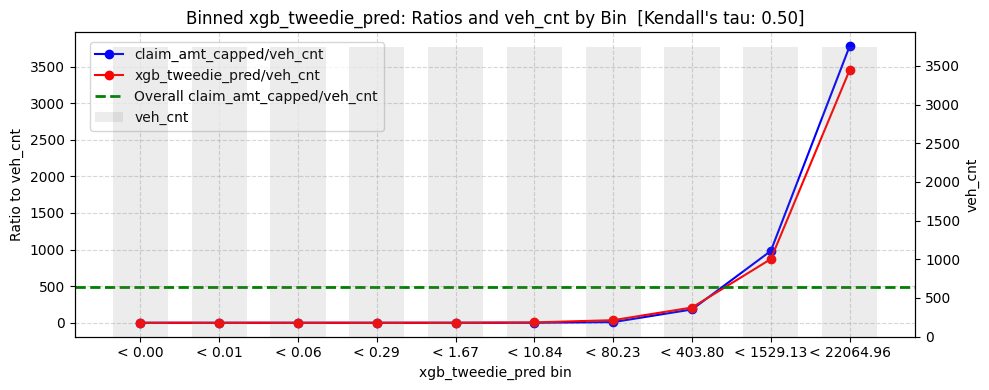

In [8]:
# Ensure the parent directory is in the path for module import
import sys
sys.path.append(os.path.abspath(".."))
from analysis_tool_chest.data_exploration import PredictivenessCheck
from analysis_tool_chest.model_selection import ModelEvaluation

# Select training samples for predictiveness check
data = train_data

# Define variables
exp_var = 'veh_cnt'
pred_var = 'xgb_tweedie_pred'
var_1 = 'claim_amt_capped'
var_2 = 'xgb_tweedie_pred'
nbins = 10


# Create and run PredictivenessCheck
pc = PredictivenessCheck(
    df=data,
    pred_var=pred_var,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2
)

pc.binning(nbins=nbins)
pc.aggregate()

# Compute top lift
pc.top_lift()

# Compute R^2, RMSE, and MAE
me = ModelEvaluation(data[var_1], data[var_2])
gini = me.gini()
r2 = me.r2()
rmse = me.rmse()
mae = me.mae()

# Print results
print(f"Top Lift: {pc.top_lift:.4f}")
print(f"Gini: {gini:.4f}")
print(f"R^2: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
pc.plot(figsize=(10, 4))


### On validation data

Top Lift: 7.6465
Gini: 0.8692
R^2: 0.7441
RMSE: 701.96
MAE: 264.66


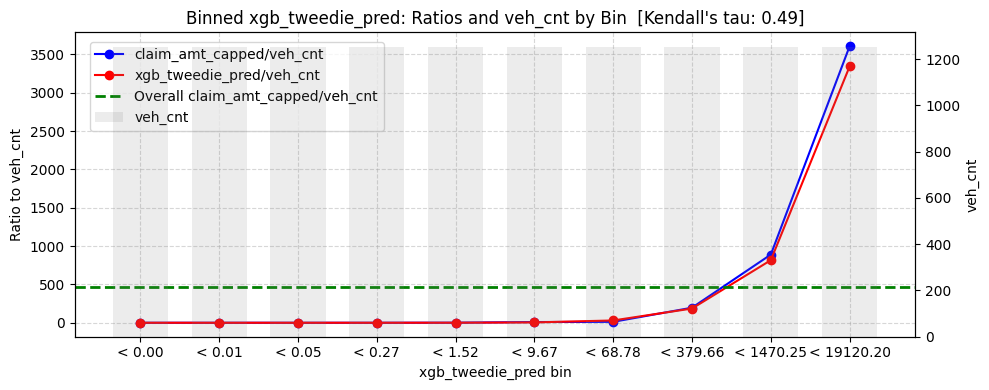

In [9]:
# Select validation sample for predictiveness check
data = val_data

# Define variables
exp_var = 'veh_cnt'
pred_var = 'xgb_tweedie_pred'
var_1 = 'claim_amt_capped'
var_2 = 'xgb_tweedie_pred'
nbins = 10


# Create and run PredictivenessCheck
pc = PredictivenessCheck(
    df=data,
    pred_var=pred_var,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2
)

pc.binning(nbins=nbins)
pc.aggregate()

# Compute top lift
pc.top_lift()

# Compute R^2, RMSE, and MAE
me = ModelEvaluation(data[var_1], data[var_2])
gini = me.gini()
r2 = me.r2()
rmse = me.rmse()
mae = me.mae()

# Print results
print(f"Top Lift: {pc.top_lift:.4f}")
print(f"Gini: {gini:.4f}")
print(f"R^2: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
pc.plot(figsize=(10, 4))

## Predict Vs Actual Check
### On training data


--- Predictiveness Plot for agecat2 ---


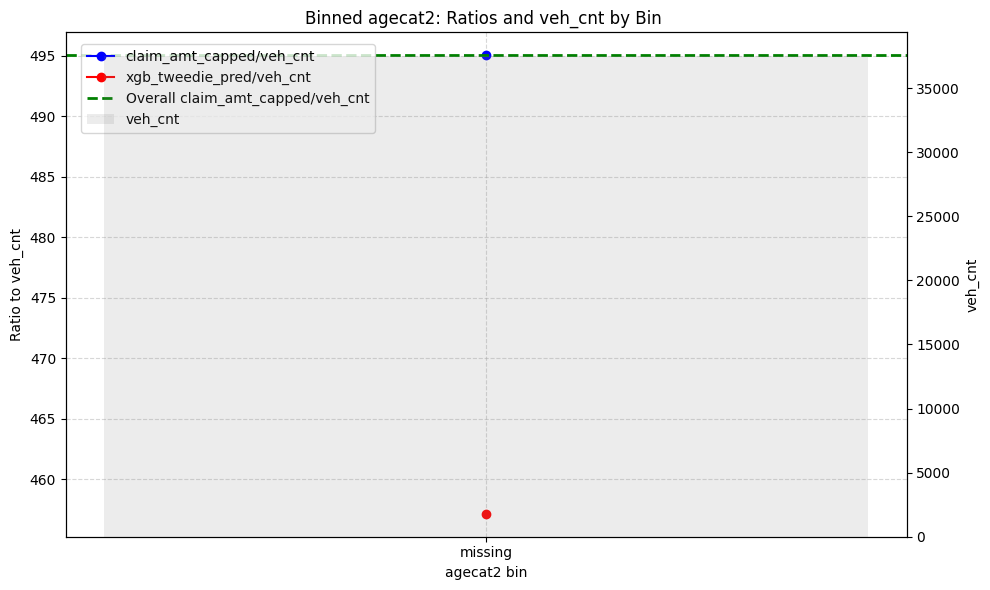


--- Predictiveness Plot for gender ---


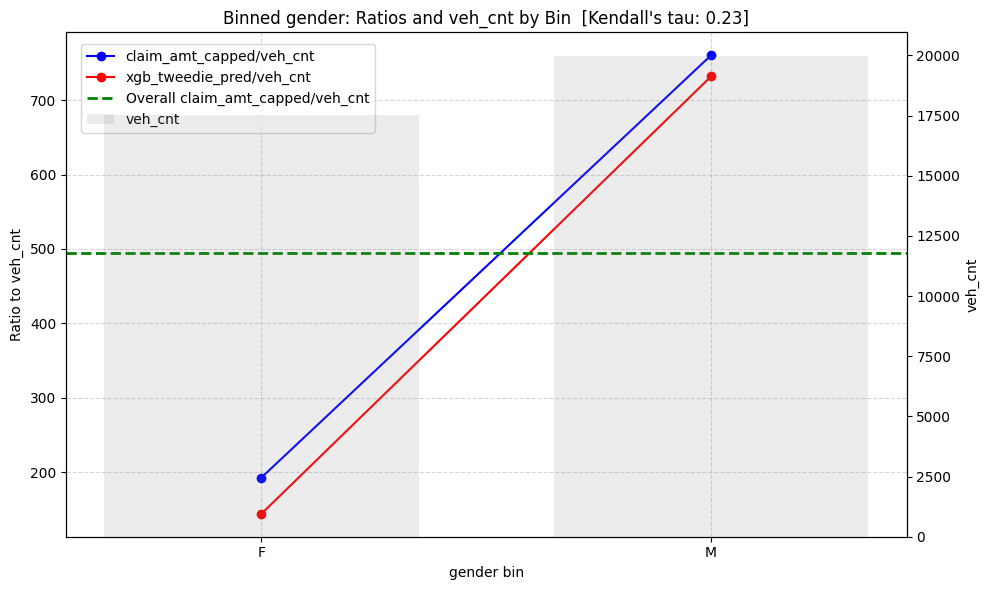


--- Predictiveness Plot for credit_score ---


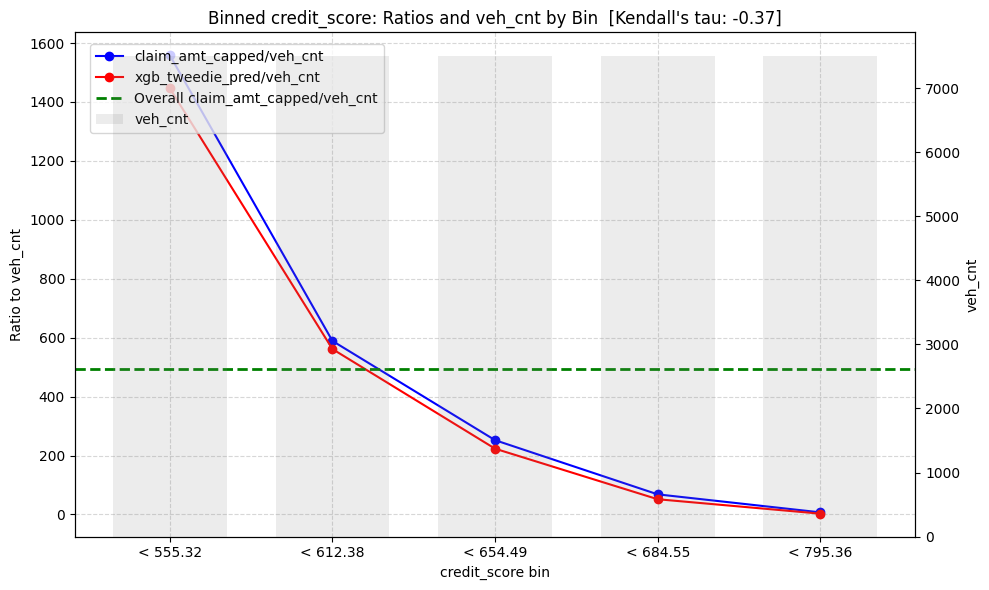


--- Predictiveness Plot for area ---


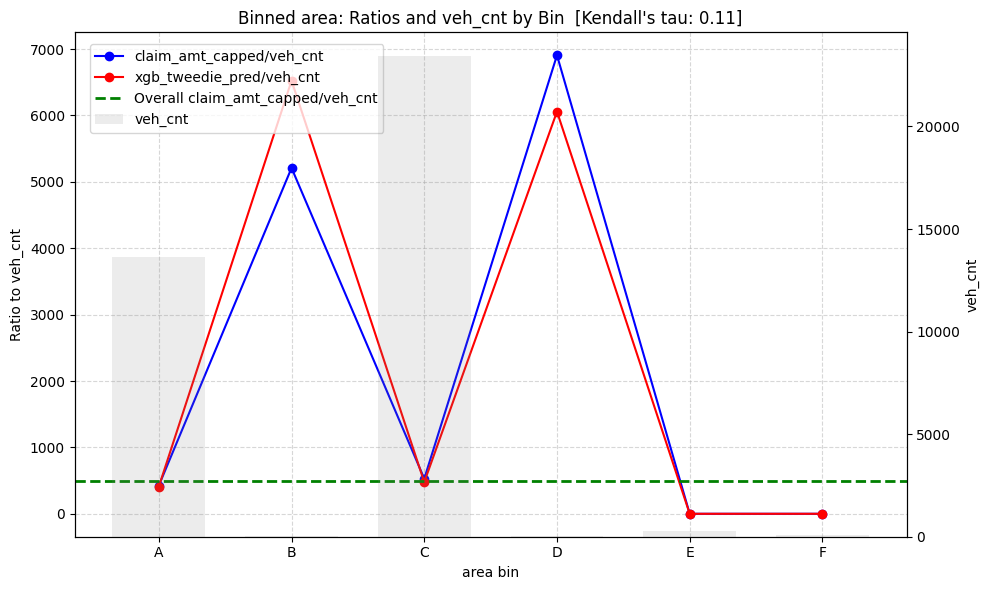


--- Predictiveness Plot for traffic_index ---


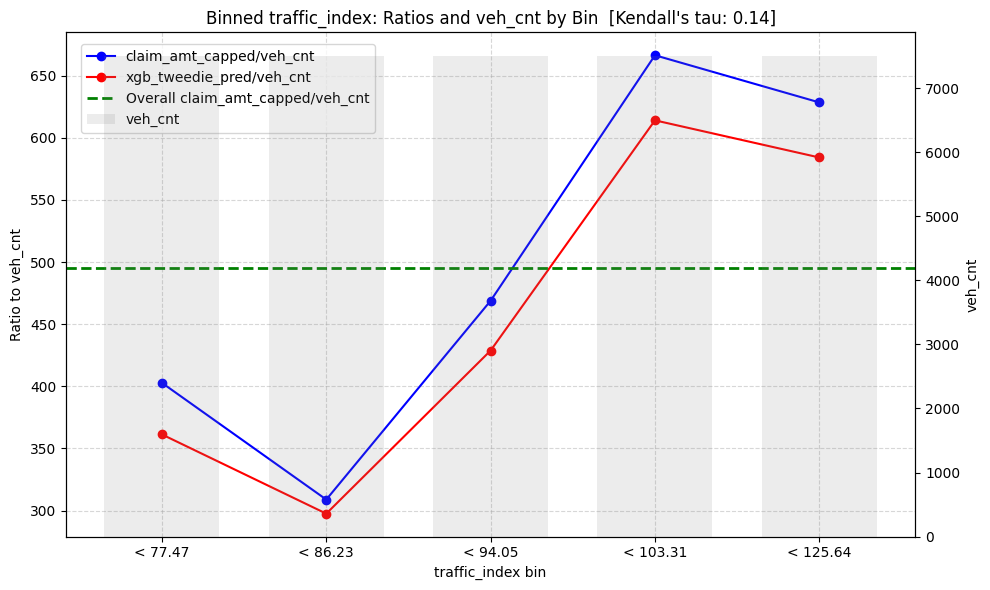


--- Predictiveness Plot for veh_age ---


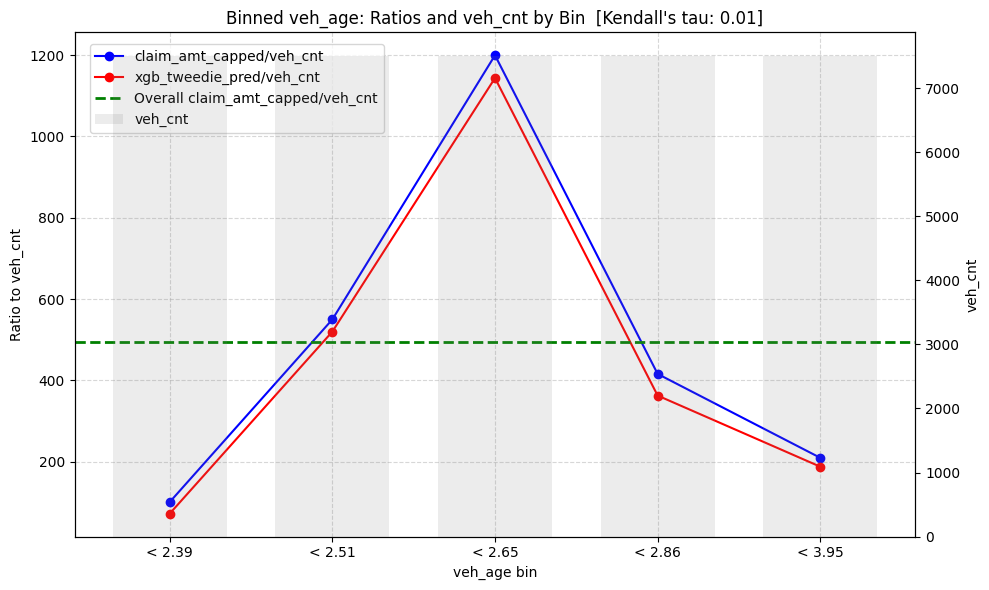


--- Predictiveness Plot for veh_body ---


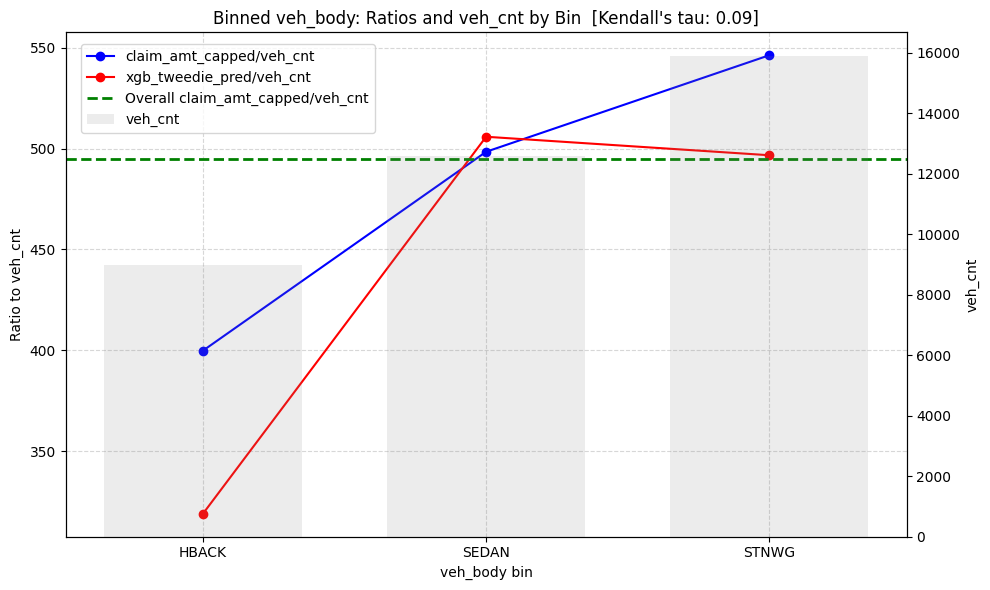


--- Predictiveness Plot for veh_value ---


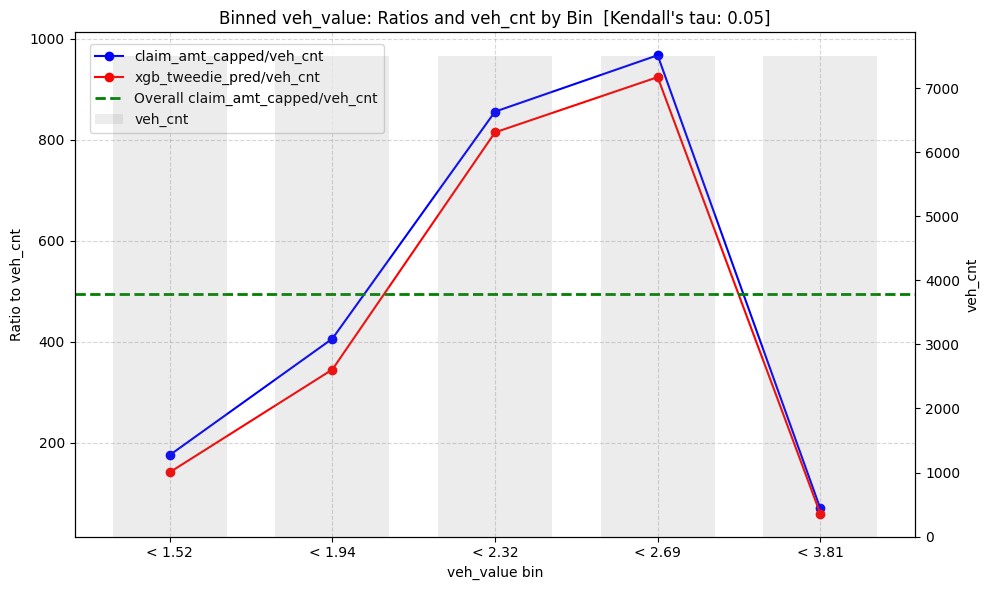

In [10]:
from analysis_tool_chest.data_exploration import PredictivenessCheckList

# Example setup
exp_var = 'veh_cnt' 
var_1 = 'claim_amt_capped'     
var_2 = 'xgb_tweedie_pred'   
nbins = 5         

# Create and run the PredictivenessCheckList
pcl = PredictivenessCheckList(
    data=train_data,
    pred_var_lst=pred_lst,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2,     
    nbins=nbins
)

pcl.run_all()
pcl.plot_all()

### On validation data


--- Predictiveness Plot for agecat2 ---


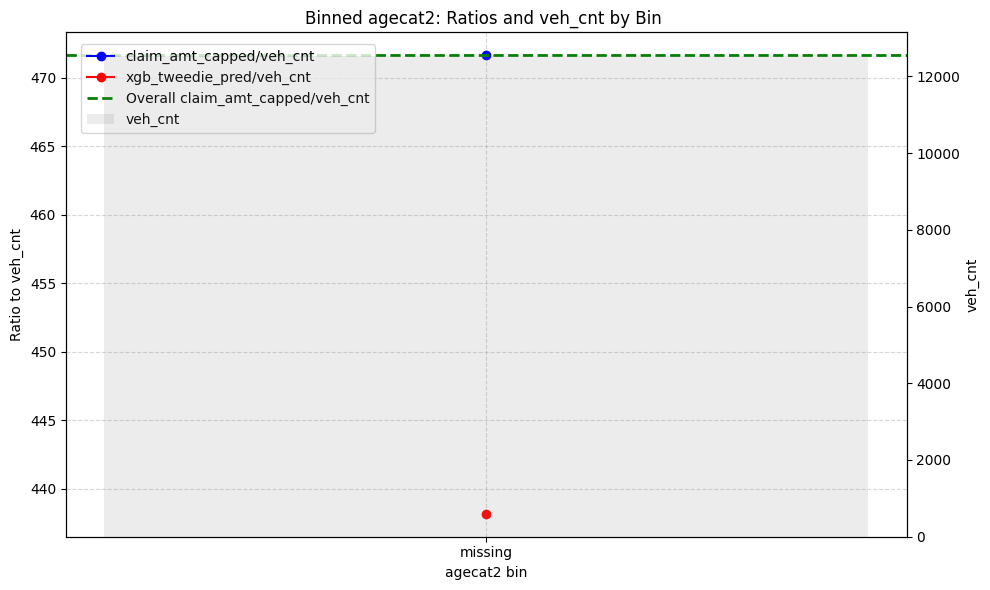


--- Predictiveness Plot for gender ---


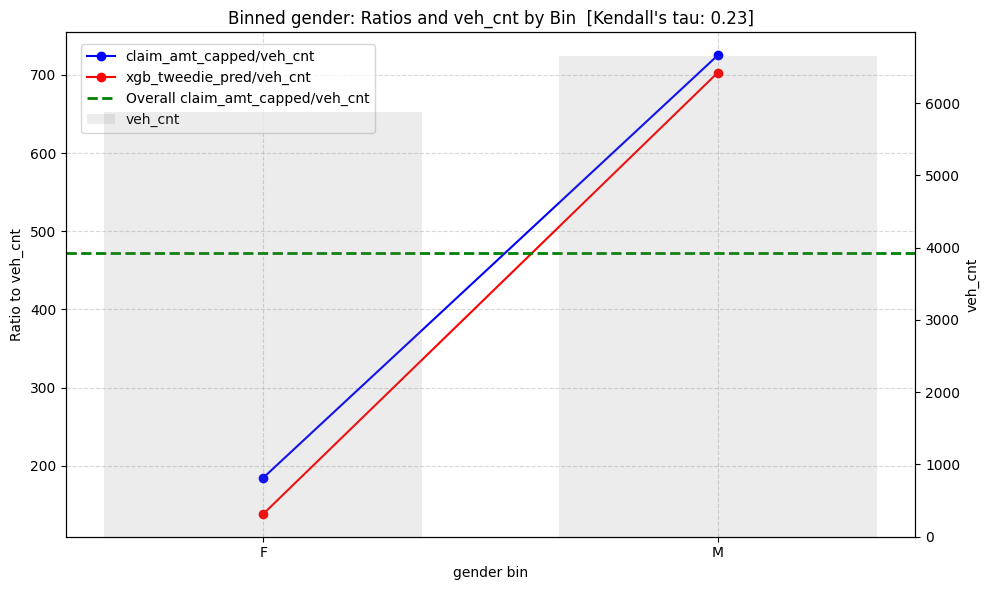


--- Predictiveness Plot for credit_score ---


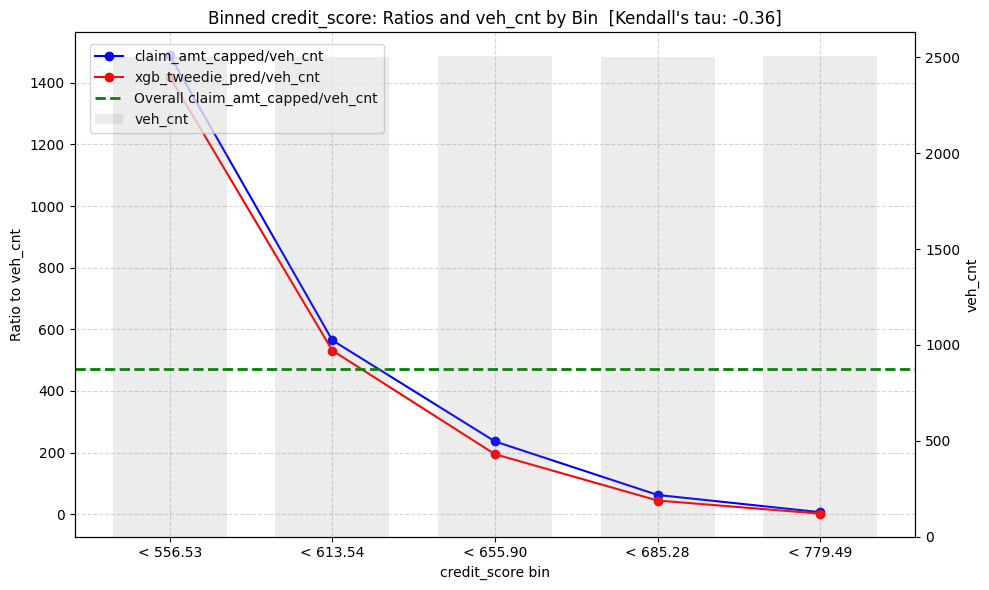


--- Predictiveness Plot for area ---


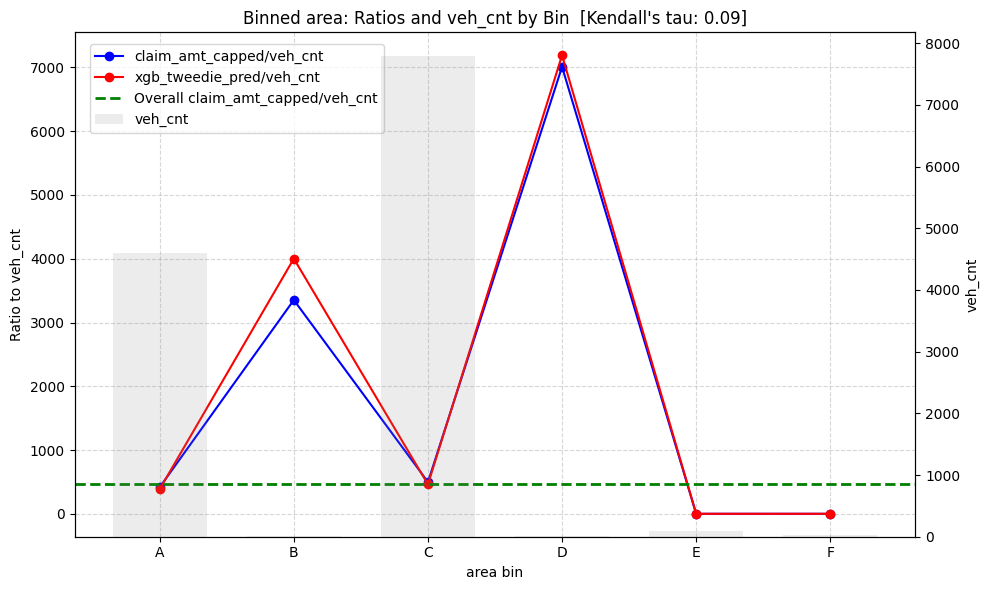


--- Predictiveness Plot for traffic_index ---


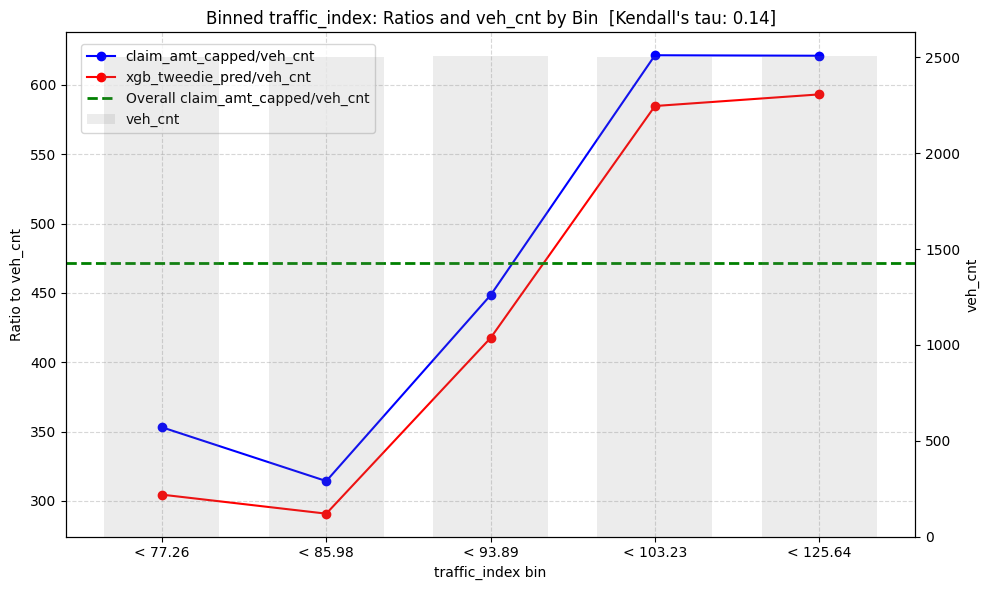


--- Predictiveness Plot for veh_age ---


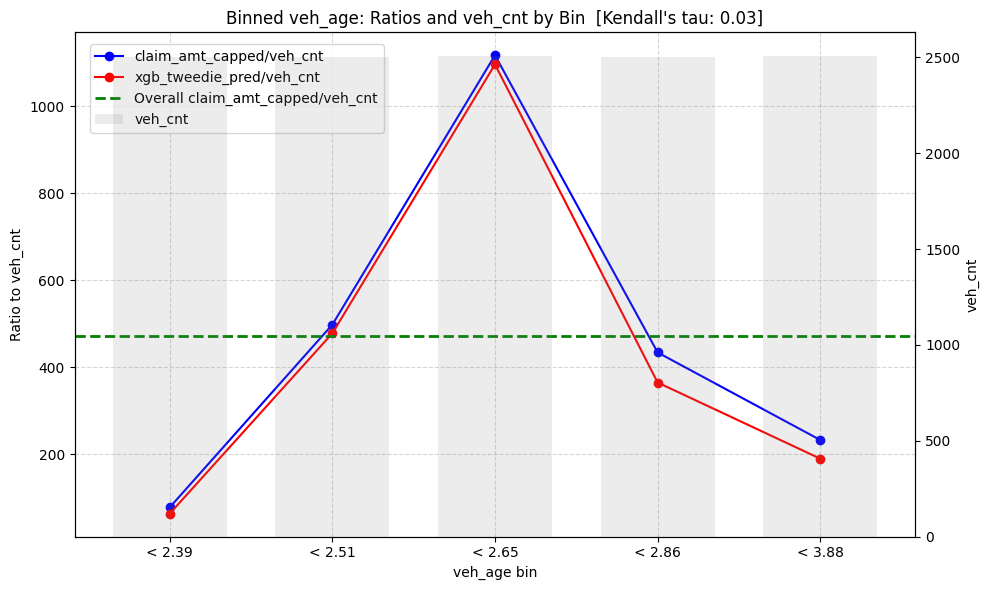


--- Predictiveness Plot for veh_body ---


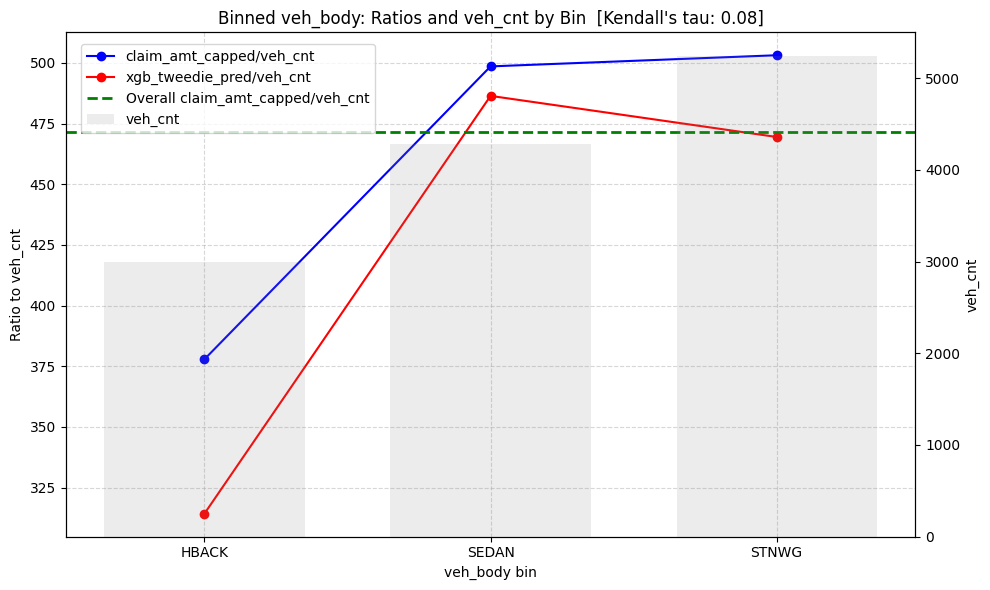


--- Predictiveness Plot for veh_value ---


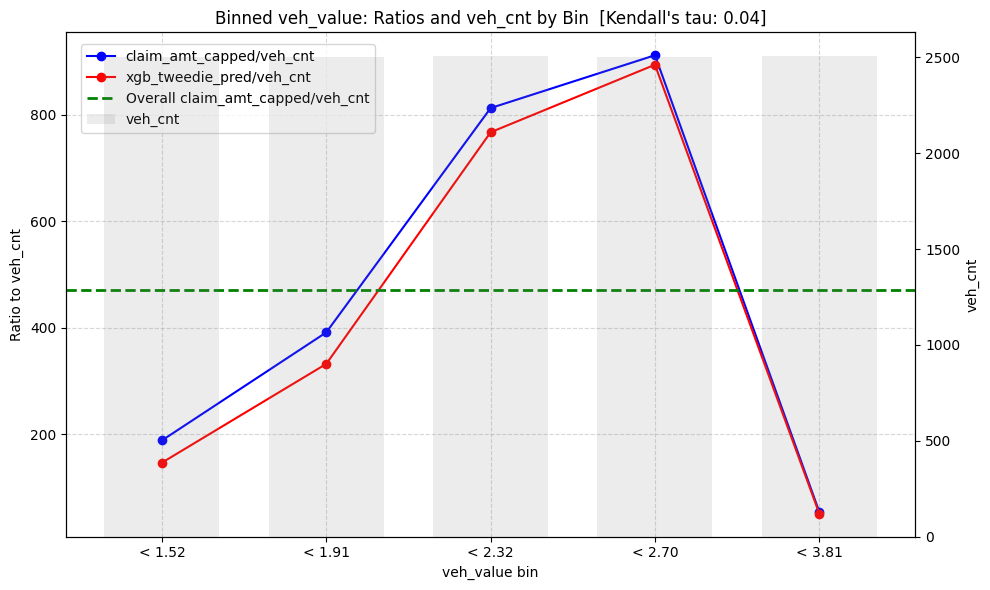

In [11]:
from analysis_tool_chest.data_exploration import PredictivenessCheckList

# Example setup
exp_var = 'veh_cnt' 
var_1 = 'claim_amt_capped'     
var_2 = 'xgb_tweedie_pred'   
nbins = 5         

# Create and run the PredictivenessCheckList
pcl = PredictivenessCheckList(
    data=val_data,
    pred_var_lst=pred_lst,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2,     
    nbins=nbins
)

pcl.run_all()
pcl.plot_all()

## <span style="color:red"><b><i>Model Selection</i></b></span>

<span style="color:red"><b><i>Task 2: Conduct hyper-parameters tunning on the tree-based model and compare the selected model performance with our base model above. Instead of doing a full panel grid search on all hyper-paramters. Let us consider an interactive hyper-parameter tunning approach to tune two to three hyper-parameters at a time. The benefits are three-folds.</i></b></span>

1. <span style="color:red"><b><i>Human charges and decisions are included.</i></b></span>
2. <span style="color:red"><b><i>Better computationally efficiency.</i></b></span>
3. <span style="color:red"><b><i>Hyper-parameter tunning according to their dependencies.</i></b></span>
4. <span style="color:red"><b><i>Better understand hyper-parameters of a tree-based model.</i></b></span>

<span style="color:red"><b><i>For interactive hypter-parameter tunning tuitorials, please refer to: 
- https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/.
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/</i></b></span>

<span style="color:red"><b><i>For sample output illustration, please refer to the plots below:</i></b></span>

<div style="background-color: #f8f8f8; padding: 10px;">
    <p style="color: black;">First, tune learning rate related hyper-parameters.</p>
    <img src="../images/4_grid_search_1.png" alt="Hypter-parameter tunning on learn rate related parameters" style="max-width:60%;">
    <p style="color: black;">Next, tune max depth and minimum rows per node.</p>
    <img src="../images/4_grid_search_2.png" alt="Hypter-parameter tunning on max depth and minimum rows" style="max-width:60%;">
</div>





<span style="color:red"><b><i>Task 3: Examine TabTPN - A Cutting Edge Transformer Based Model on Tabular Data. Specific to-dos: </i></b></span>
1. <span style="color:red"><b><i>Read and summarize the paper: https://arxiv.org/abs/2207.01848.</i></b></span>
2. <span style="color:red"><b><i>Examine TabTPN on our data and compare its performance with the other models built and the base model. Some sample code can be found on TabTPN's GitHub page: https://github.com/PriorLabs/TabPFN.</i></b></span>

<span style="color:red"><b><i>Task 4: Build another type of model (possible candidates: linear model and composite model, please do not build another tree-based models nor deep learning models) and compare its performance with the other models built and the base model above.

<span style="color:red"><b><i>One possible solution: Build a composite model to predict total loss. Specific to-dos: </i></b></span>

1. <span style="color:red"><b><i>Build a frequency model: Poisson Log-likelihood as the object function; 'claim_cnt' column as the target variable.</i></b></span> 
2. <span style="color:red"><b><i>Build a severity model: Gamma Log-likelihood as the object function; 'claim_sev_capped' column as the target variable; Remember to only use policy terms with positive losses.</i></b></span>  
3. <span style="color:red"><b><i>Derive the total loss predictions of each policy term via combining the predictions from the frequency model and severity model.</i></b></span> 
4. <span style="color:red"><b><i>Compare its performance with the other models built and the base model.</i></b></span> 

<span style="color:red"><b><i>Task 5: Conclude the pros and cons of the linear models, tree-based models (decision tree and ensemble tree models), deep learning models (use TabTPN as an example) and any other models you have considered in this project. </i></b></span>